In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import math
from sklearn.metrics import accuracy_score

In [2]:
from collections import Counter
df1=pd.read_csv('train.csv')
X_train = df1.drop('y', axis=1)
y_train = df1['y']

df2 = pd.read_csv('test.csv')
X_test = df2.drop('y', axis=1)
y_test = df2['y']

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

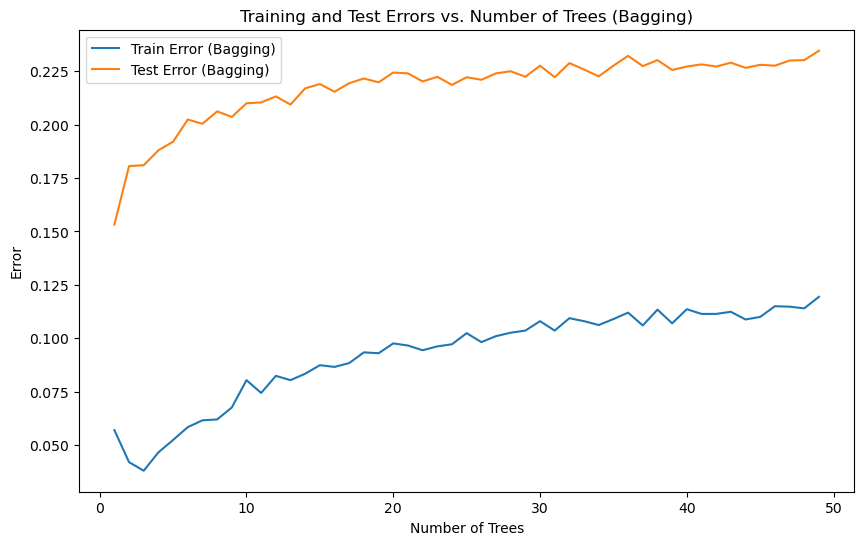

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

class TreeNode:
    def __init__(self, attribute, attributeName, is_leaf, label, depth, info_gain, entropy_parent_attr, parent_attr_val):
        self.attribute = attribute
        self.attributeName = attributeName
        self.children = {}
        self.is_leaf = is_leaf
        self.label = label
        self.depth = depth
        self.info_gain = info_gain
        self.entropy_parent_attr = entropy_parent_attr
        self.parent_attr_val = parent_attr_val

    def get_attribute(self):
        return self.attribute

    def add_child(self, child_node, attr_value):
        self.children[attr_value] = child_node
    
    def predict(self, x):
        if self.is_leaf:
            return self.label
        current_val = x[self.attribute]
        if current_val not in self.children.keys():
            return self.label
        return self.children[current_val].predict(x)

    def print_node(self, space=""):
        print(f"{space}Depth: {self.depth}")
        print(f"{space}Selected Feature: {self.attributeName}")
        print(f"{space}Information Gain for Parent Feature: {self.info_gain}")
        print(f"{space}Entropy for Parent Feature: {self.entropy_parent_attr}")
        print(f"{space}Parent Feature Value: {self.parent_attr_val}")
        print(f"{space}Label: {self.label}")
        for child in self.children.values():
            child.print_node(space + "\t")

    def _majority_error(self, X, y, attribute):
        values = set(X[attribute])
        return sum([(X[attribute] == value).mean() *
            (1 - Counter(y[X[attribute] == value]).most_common(1)[0][1] / len(y[X[attribute] == value]))
                    for value in values])

    def _gini(self, X, y, attribute):
        values = set(X[attribute])
        gini = 1
        for value in values:
            p = (X[attribute] == value).mean()
            gini -= p**2
        return gini

class DecisionTreeClassifier:
    def __init__(self, max_depth=np.inf):
        self.root = None
        self.depth = 0
        if max_depth < 1:
            print("max_depth cannot be lower than 1! Setting it to 1.")
            max_depth = 1
        self.max_depth = max_depth
        self.longest_path_len = 0

    def build_tree(self, X, Y, attribute_names, attribute_list=[], current_depth=0,
                   parent_info={"max_info_gain": None, "attribute_list[max_attribute]": None, "value": None}):
        if current_depth > self.longest_path_len:
            self.longest_path_len = current_depth
        if current_depth >= self.max_depth or len(attribute_list) == 0 or len(np.unique(Y)) == 1:
            vals, counts = np.unique(Y, return_counts=True)
            return TreeNode(None, None, True, vals[np.argmax(counts)], current_depth,
                            parent_info["max_info_gain"], parent_info["attribute_list[max_attribute]"],
                            parent_info["value"])

        max_info_gain = -1
        max_attribute = None
        i = 0
        for attribute in attribute_list:
            info_gain, entropy_attribute, entropy_parent = self.calculate_information_gain(X, Y, attribute)
            if info_gain > max_info_gain:
                max_info_gain = info_gain
                max_attribute = i
                entropy = entropy_parent
            i += 1

        vals, counts = np.unique(Y, return_counts=True)
        root = TreeNode(attribute_list[max_attribute], attribute_names[attribute_list[max_attribute]],
                        False, vals[np.argmax(counts)], current_depth,
                        parent_info["max_info_gain"], parent_info["attribute_list[max_attribute]"],
                        parent_info["value"])

        attribute_values = np.unique(X[:, attribute_list[max_attribute]])
        new_attribute_list = np.delete(attribute_list, max_attribute)
        for value in attribute_values:
            indices = np.where(X[:, attribute_list[max_attribute]] == value)[0]
            if len(indices) == 0:
                root.add_child(TreeNode(None, None, True, vals[np.argmax(counts)], current_depth + 1,
                                        max_info_gain, attribute_list[max_attribute], value), current_depth)
            else:
                parent_info = {
                    "max_info_gain": max_info_gain,
                    "attribute_list[max_attribute]": entropy,
                    "value": value
                }
                root.add_child(self.build_tree(X[indices], Y[indices], attribute_names, new_attribute_list,
                                               current_depth + 1, parent_info), value)
        return root

    def calculate_entropy(self, counts):
        total = sum(counts)
        entropy_value = 0
        for element in counts:
            p = (element / total)
            if p != 0:
                entropy_value -= p * np.log2(p)
        return entropy_value

    def calculate_information_gain(self, X, Y, attribute):
        _, counts = np.unique(Y, return_counts=True)
        entropy_attribute = self.calculate_entropy(counts)
        entropy_parent = 0
        distinct_attr_values = list(set(X[:, attribute]))
        for val in distinct_attr_values:
            indices = np.where(X[:, attribute] == val)[0]
            _, counts = np.unique(Y[indices], return_counts=True)
            entr = self.calculate_entropy(counts)
            entropy_parent += (len(indices) / len(Y)) * entr
        info_gain = entropy_attribute - entropy_parent
        return info_gain, entropy_attribute, entropy_parent

    def fit(self, X, Y):
        attribute_names = list(range(X.shape[1]))  # Assume attributes are indexed
        attribute_list = np.arange(X.shape[1])
        self.root = self.build_tree(X, Y, attribute_names, attribute_list, 0)

    def predict(self, X):
        predictions = []
        for i in range(X.shape[0]):
            predictions.append(self.root.predict(X[i]))
        return predictions

    def get_longest_path_len(self):
        return self.longest_path_len

    def get_root_attribute(self):
        if self.root:
            return self.root.get_attribute()
        return None

    def print_tree(self):
        self.root.print_node("")
        
class BaggedTreesClassifier:
    def __init__(self, num_trees):
        self.num_trees = num_trees
        self.trees = []

    def fit(self, X, y):
        n_samples = X.shape[0]
        for _ in range(self.num_trees):
            # Create a bootstrap sample
            indices = np.random.choice(n_samples, n_samples, replace=True)
            X_bootstrap, y_bootstrap = X[indices], y[indices]

            # Train a decision tree on the bootstrap sample
            dt_classifier = DecisionTreeClassifier(max_depth=np.inf)
            dt_classifier.fit(X_bootstrap, y_bootstrap)
            self.trees.append(dt_classifier)

    def predict(self, X):
        predictions = np.zeros(X.shape[0])
        for tree in self.trees:
            predictions += tree.predict(X)
        return np.sign(predictions)

# Load data
train_df = pd.read_csv("train.csv")
X_train = train_df.drop('y', axis=1).values
y_train = train_df['y'].apply(lambda x: 1 if x == 'yes' else 0).values.astype(float)

test_df = pd.read_csv("test.csv")
X_test = test_df.drop('y', axis=1).values
y_test = test_df['y'].apply(lambda x: 1 if x == 'yes' else 0).values.astype(float)

# Vary the number of trees from 1 to 500
num_trees_range = range(1, 500)
train_errors_bagging = []
test_errors_bagging = []

for num_trees in num_trees_range:
    # Create and fit the Bagged Trees classifier
    bagged_trees_classifier = BaggedTreesClassifier(num_trees)
    bagged_trees_classifier.fit(X_train, y_train)

    # Predict using the trained classifier
    y_train_pred = bagged_trees_classifier.predict(X_train)
    y_test_pred = bagged_trees_classifier.predict(X_test)

    # Calculate training and test errors
    train_error = 1 - accuracy_score(y_train, y_train_pred)
    test_error = 1 - accuracy_score(y_test, y_test_pred)

    train_errors_bagging.append(train_error)
    test_errors_bagging.append(test_error)

# Plotting the errors
plt.figure(figsize=(10, 6))
plt.plot(num_trees_range, train_errors_bagging, label='Train Error (Bagging)')
plt.plot(num_trees_range, test_errors_bagging, label='Test Error (Bagging)')
plt.xlabel('No of Trees')
plt.ylabel('Error')
plt.title('Training and Test Errors vs. Number of Trees (Bagging)')
plt.legend()
plt.show()


In [26]:
import numpy as np

# Function to compute bias and variance
def compute_bias_variance(predictions, ground_truth):
    # Compute bias (average prediction - ground-truth label)
    bias = np.mean(predictions) - ground_truth

    # Compute variance
    variance = np.var(predictions)

    return bias, variance

# Function to perform the experiment
# Function to perform the experiment
# Function to perform the experiment
def run_experiment(X_train, y_train, X_test, y_test, num_iterations=100, num_bagged_trees=500):
    single_tree_biases = []
    single_tree_variances = []
    bagged_tree_biases = []
    bagged_tree_variances = []

    for _ in range(num_iterations):
        # Step 1: Sample 1,000 examples uniformly without replacement from the training dataset
        n_samples = X_train.shape[0]
        sample_indices = np.random.choice(n_samples, size=1000, replace=False)
        sampled_X_train, sampled_y_train = X_train[sample_indices], y_train[sample_indices]


        # Step 2: Run bagged trees learning algorithm based on the 1,000 training examples and learn 500 trees
        bagged_trees_classifier = BaggedTreesClassifier(num_bagged_trees)
        bagged_trees_classifier.fit(sampled_X_train, sampled_y_train)

        # Step 3: Compute bias and variance for single trees and bagged trees
        # Single trees
        single_tree_predictions = np.array([tree.predict(X_test) for tree in bagged_trees_classifier.trees])
        avg_single_tree_predictions = np.mean(single_tree_predictions, axis=0)
        single_tree_bias, single_tree_variance = compute_bias_variance(avg_single_tree_predictions, y_test)
        single_tree_biases.append(single_tree_bias)
        single_tree_variances.append(single_tree_variance)

        # Bagged trees
        bagged_tree_predictions = bagged_trees_classifier.predict(X_test)
        bagged_tree_bias, bagged_tree_variance = compute_bias_variance(bagged_tree_predictions, y_test)
        bagged_tree_biases.append(bagged_tree_bias)
        bagged_tree_variances.append(bagged_tree_variance)

    # Calculate average bias, variance, and general squared error
    avg_single_tree_bias = np.mean(single_tree_biases)
    avg_single_tree_variance = np.mean(single_tree_variances)
    avg_bagged_tree_bias = np.mean(bagged_tree_biases)
    avg_bagged_tree_variance = np.mean(bagged_tree_variances)

    return avg_single_tree_bias, avg_single_tree_variance, avg_bagged_tree_bias, avg_bagged_tree_variance

# Run the experiment
avg_single_tree_bias, avg_single_tree_variance, avg_bagged_tree_bias, avg_bagged_tree_variance = run_experiment(
    X_train, y_train, X_test, y_test)

# Print the results
print("Average bias for single decision tree:", avg_single_tree_bias)
print("Average variance for single decision tree:", avg_single_tree_variance)
print("Average bias for bagged trees:", avg_bagged_tree_bias)
print("Average variance for bagged trees:", avg_bagged_tree_variance)


Average bias for single decision tree: -0.10132238400000002
Average variance for single decision tree: 0.010392693750592001
Average bias for bagged trees: 0.018219999999999997
Average variance for bagged trees: 0.12158494239999998
